In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence

#Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_theme(style="whitegrid")

In [2]:
#change directory for your path
os.chdir('E:\\OneDrive\\Documents\\GitHub\\eHealthEquity\\Research\\Data Source')

In [3]:
df = pd.read_csv('final_merge.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   county                      3076 non-null   object 
 1   state                       3076 non-null   object 
 2   ruca                        3073 non-null   float64
 3   brfss_access2_ageadjprv     3076 non-null   float64
 4   brfss_checkup_ageadjprv     3076 non-null   float64
 5   brfss_csmoking_ageadjprv    3076 non-null   float64
 6   brfss_depression_ageadjprv  3076 non-null   float64
 7   brfss_diabetes_ageadjprv    3076 non-null   float64
 8   brfss_ghlth_ageadjprv       3076 non-null   float64
 9   brfss_mhlth_ageadjprv       3076 non-null   float64
 10  brfss_obesity_ageadjprv     3076 non-null   float64
 11  pct_ed_lt9                  3076 non-null   float64
 12  pct_ed_9_12                 3076 non-null   float64
 13  pct_ed_hs                   3076 

In [35]:
dv = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
iv = [
    'pct_dg_bb_int' # percentage of households with broadband internet access
]

covariates = [
    #'brfss_access2_ageadjprv',
    'brfss_checkup_ageadjprv',
    #'brfss_csmoking_ageadjprv',
    #'brfss_depression_ageadjprv',
    #'brfss_ghlth_ageadjprv',
    'brfss_mhlth_ageadjprv',
    'brfss_obesity_ageadjprv',
    'pct_ed_lt9',
    'pct_ed_9_12',
    'pct_ed_hs',
    #'pct_ed_sc',
    'pct_ed_asc',
    #'pct_ed_b',
    #'pct_ed_gr',
    'pct_age_gte65',
    #'pct_race_white',
    'pct_race_black',
    'pct_race_aian',
    'pct_race_asian',
    'pct_race_nhopi',
    'pct_race_other',
    #'pct_eth_hisp',
    'pct_sex_male',
    #'pct_sex_female',
    'pct_occ_unemp',
    #'pct_occ_mgt',
    #'pct_occ_svc',
    #'pct_occ_sales',
    #'pct_occ_nat_res',
    #'pct_occ_prod',
    'pct_hlth_unins',
    'pct_ses_pov',
    'pct_tp_veh_0',
    #'pct_tp_veh_1',
    #'pct_tp_veh_2',
    #'pct_tp_veh_3',
    'bb_int_struct',
    #'ruca_metro',
    #'ruca_micro',
    #'ruca_small_town',
    'ruca_rural'
]

# variables commented out due to high VIF values (>= 5)


In [52]:
X = df[iv + covariates]
y = df[dv]
#center X
X = X - X.mean()
#add constant
X = sm.add_constant(X)

# Linear Regression and Assumptions Check

                     Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.926    
Dependent Variable: brfss_diabetes_ageadjprv AIC:                5765.2651
Date:               2024-02-12 11:56         BIC:                5897.9556
No. Observations:   3076                     Log-Likelihood:     -2860.6  
Df Model:           21                       F-statistic:        1828.    
Df Residuals:       3054                     Prob (F-statistic): 0.00     
R-squared:          0.926                    Scale:              0.37881  
--------------------------------------------------------------------------
                           Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                     10.5643   0.0111 951.9777 0.0000 10.5426 10.5861
pct_dg_bb_int             -0.0057   0.0024  -2.3956 0.0167 -0.0104 -0.0010
brfss_checkup_ageadjprv    0.0169   0.0036   4.

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.870,0.350,pct_dg_bb_int
2,2.140,0.470,brfss_checkup_ageadjprv
3,3.740,0.270,brfss_mhlth_ageadjprv
4,2.700,0.370,brfss_obesity_ageadjprv
5,2.200,0.450,pct_ed_lt9
6,3.240,0.310,pct_ed_9_12
7,2.520,0.400,pct_ed_hs
8,1.580,0.630,pct_ed_asc
9,1.770,0.560,pct_age_gte65


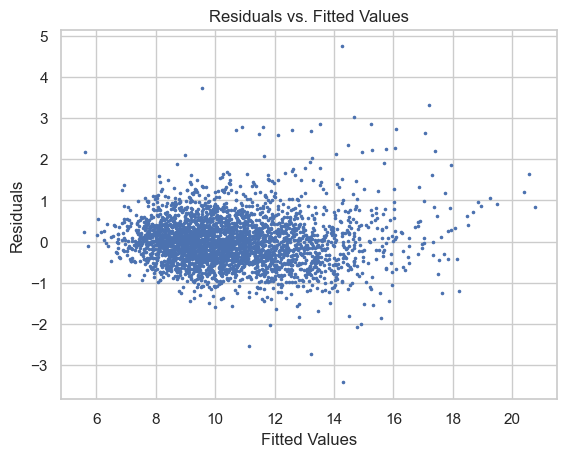

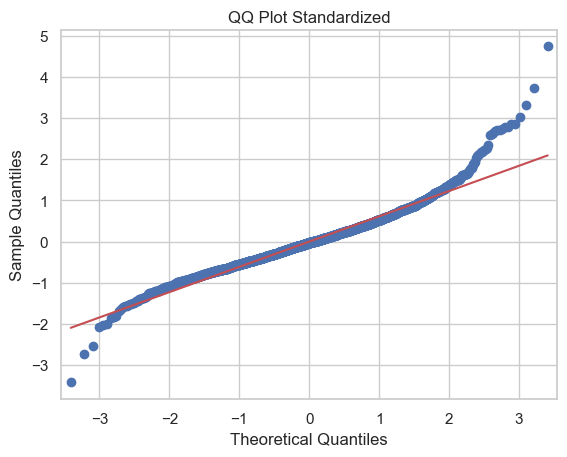

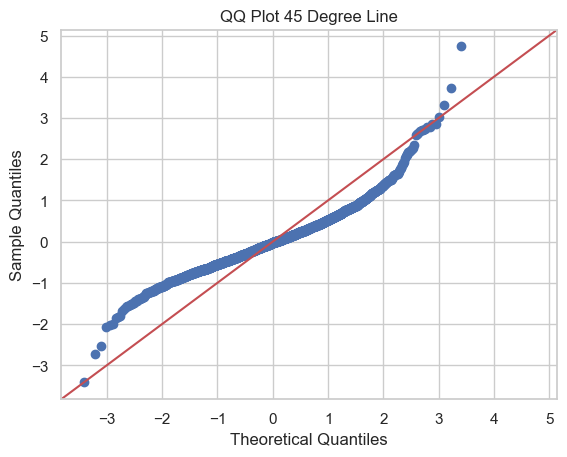

In [53]:
model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

In [54]:
summary_df = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index':'feature'})
print(summary_df)

                    feature   coef  std err       t  P>|t|  [0.025  0.975]
0                     const 10.564    0.011 951.978  0.000  10.543  10.586
1             pct_dg_bb_int -0.006    0.002  -2.396  0.017  -0.010  -0.001
2   brfss_checkup_ageadjprv  0.017    0.004   4.634  0.000   0.010   0.024
3     brfss_mhlth_ageadjprv  0.148    0.010  14.707  0.000   0.129   0.168
4   brfss_obesity_ageadjprv  0.115    0.004  28.689  0.000   0.107   0.123
5                pct_ed_lt9  0.094    0.005  19.794  0.000   0.085   0.103
6               pct_ed_9_12  0.067    0.006  11.462  0.000   0.055   0.078
7                 pct_ed_hs -0.000    0.002  -0.169  0.866  -0.005   0.004
8                pct_ed_asc -0.010    0.005  -2.150  0.032  -0.019  -0.001
9             pct_age_gte65 -0.009    0.003  -2.985  0.003  -0.016  -0.003
10           pct_race_black  0.044    0.001  37.975  0.000   0.042   0.046
11            pct_race_aian  0.023    0.002  11.212  0.000   0.019   0.027
12           pct_race_asi

In [55]:
#create a equation for the model in latex
def latex_eq(coefficients, dv):
    eq = dv + ' = '
    for i in range(len(coefficients)):
        if i == 0:
            eq += str(round(coefficients[i], 3))
        else:
            eq += ' + ' + str(round(coefficients[i], 3)) + ' ' + str(summary_df['feature'][i])
    return eq

print(latex_eq(results.params, dv[0]))


brfss_diabetes_ageadjprv = 10.564 + -0.006 pct_dg_bb_int + 0.017 brfss_checkup_ageadjprv + 0.148 brfss_mhlth_ageadjprv + 0.115 brfss_obesity_ageadjprv + 0.094 pct_ed_lt9 + 0.066 pct_ed_9_12 + -0.0 pct_ed_hs + -0.01 pct_ed_asc + -0.01 pct_age_gte65 + 0.044 pct_race_black + 0.023 pct_race_aian + 0.059 pct_race_asian + -0.042 pct_race_nhopi + 0.048 pct_race_other + 0.029 pct_sex_male + 0.014 pct_occ_unemp + 0.047 pct_hlth_unins + 0.109 pct_ses_pov + -0.013 pct_tp_veh_0 + -0.279 bb_int_struct + -0.034 ruca_rural


In [56]:
fit_measures = pd.DataFrame()
fit_measures['MAE'] = [mae]
fit_measures['RMSE'] = [rmse]
fit_measures['R2'] = [results.rsquared]
fit_measures['Adj. R2'] = [results.rsquared_adj]
fit_measures['F-statistic'] = [results.fvalue]
fit_measures['p-value'] = [results.f_pvalue]
fit_measures['AIC'] = [results.aic]
fit_measures['BIC'] = [results.bic]
fit_measures['Log-Likelihood'] = [results.llf]
fit_measures['df_resid'] = [results.df_resid]
fit_measures['df_model'] = [results.df_model]

display(fit_measures.round(2))

,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.450,0.610,0.930,0.930,1827.880,0.000,5765.270,5897.960,-2860.630,3054.000,21.000


## Outlier Assessment and Removal 

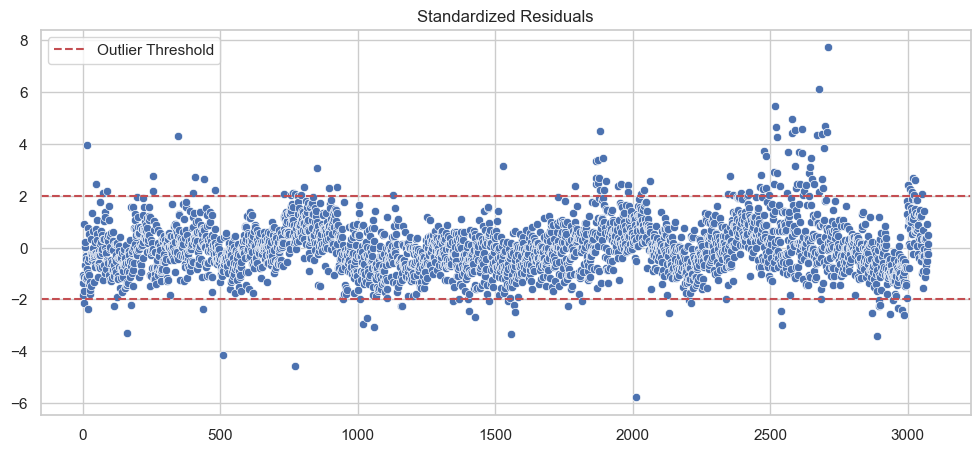

False    2895
True      181
Name: outliers, dtype: int64

0.0013003901170351106
3076


In [57]:
#outlier detection Cook's Distance
influence = OLSInfluence(results)
standardized_residuals = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance

plt.figure(figsize=(12, 5))
sns.scatterplot(x=range(len(standardized_residuals)), y=standardized_residuals)
plt.axhline(y=2, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-2, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.legend()
plt.show()

df_outliers = df.copy()
df_outliers['standardized_residuals'] = standardized_residuals
df_outliers['leverage'] = leverage
df_outliers['cooks_d'] = cooks_d[0]

#identify outliers using Cook's Distance 4/(n-k-1)
df_outliers['outliers'] = df_outliers['cooks_d'] > (4/(len(df_outliers)-len(iv)-1))
df_outliers[df_outliers['outliers'] == True]
display(df_outliers['outliers'].value_counts())

print(4/len(df_outliers))
print(len(df_outliers))


In [58]:
# remove outliers
df_no_outliers = df_outliers[df_outliers['outliers'] == False]
#drop outlier columns
df_no_outliers = df_no_outliers.drop(columns=['standardized_residuals', 'leverage', 'cooks_d', 'outliers'])
# set x and y with outliers removed
X = df_no_outliers[iv + covariates]
y = df_no_outliers[dv]
#center X
X = X - X.mean()
#add constant
X = sm.add_constant(X)

                     Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.946    
Dependent Variable: brfss_diabetes_ageadjprv AIC:                3983.1250
Date:               2024-02-12 11:56         BIC:                4114.4813
No. Observations:   2895                     Log-Likelihood:     -1969.6  
Df Model:           21                       F-statistic:        2397.    
Df Residuals:       2873                     Prob (F-statistic): 0.00     
R-squared:          0.946                    Scale:              0.23002  
--------------------------------------------------------------------------
                          Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                    10.3933   0.0089 1165.9871 0.0000 10.3758 10.4108
pct_dg_bb_int            -0.0019   0.0021   -0.9066 0.3647 -0.0059  0.0022
brfss_checkup_ageadjprv   0.0284   0.0031    9.

,VIF,Tolerance,features
0,1.000,1.000,const
1,2.920,0.340,pct_dg_bb_int
2,2.130,0.470,brfss_checkup_ageadjprv
3,4.180,0.240,brfss_mhlth_ageadjprv
4,2.570,0.390,brfss_obesity_ageadjprv
5,2.350,0.420,pct_ed_lt9
6,3.550,0.280,pct_ed_9_12
7,2.740,0.370,pct_ed_hs
8,1.610,0.620,pct_ed_asc
9,1.720,0.580,pct_age_gte65


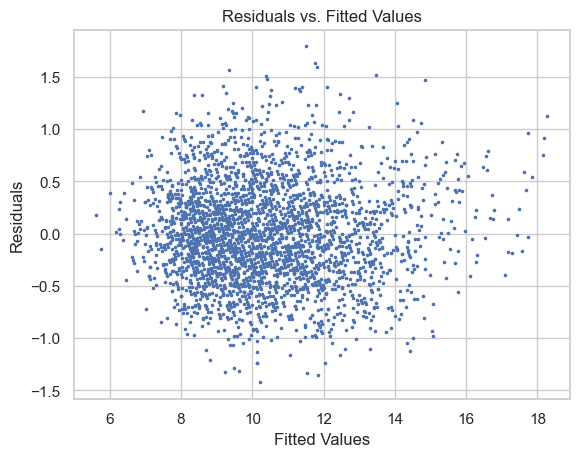

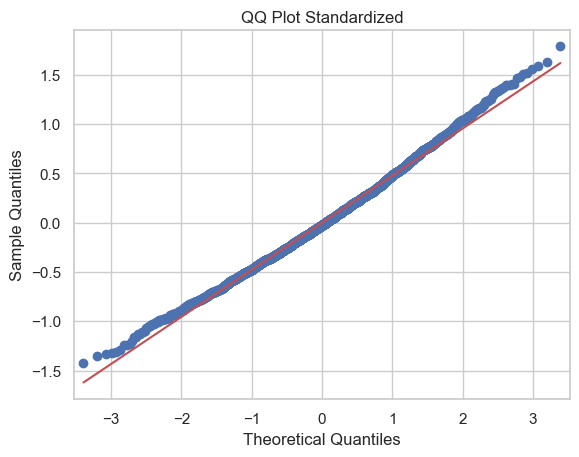

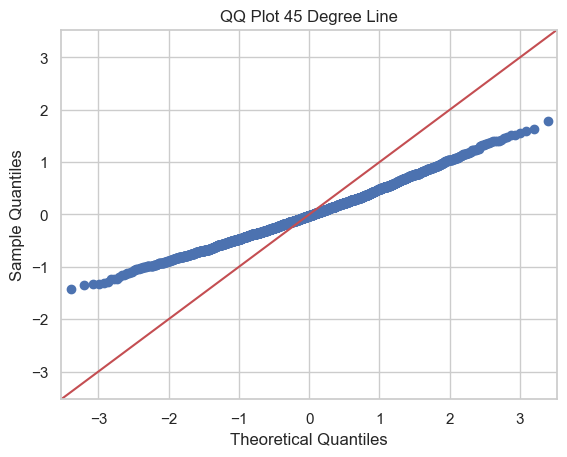

In [59]:
model = sm.OLS(y, X)
results = model.fit()

#Evalute VIF for each variable and display in table
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / tolerance for tolerance in vif["VIF"]]
vif["features"] = X.columns

#Make MAE and RMSE scores 
mae = np.mean(np.abs(results.resid))
rmse = np.sqrt(np.mean(results.resid**2))

#Reg Model Summary, MAE, and VIF display
print(results.summary2())
print("MAE: ", mae)
print("RMSE: ", rmse)
display(vif.round(2))

#Assess for heteroskedasticity and normality of residuals
residuals = results.resid
plt.scatter(results.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot with Standardized line
sm.qqplot(residuals, line='s')
plt.title('QQ Plot Standardized')
plt.show()

#QQ Plot with 45 degree line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot 45 Degree Line')
plt.show()

In [60]:
fit_measures_2 = pd.DataFrame()
fit_measures_2['MAE'] = [mae]
fit_measures_2['RMSE'] = [rmse]
fit_measures_2['R2'] = [results.rsquared]
fit_measures_2['Adj. R2'] = [results.rsquared_adj]
fit_measures_2['F-statistic'] = [results.fvalue]
fit_measures_2['p-value'] = [results.f_pvalue]
fit_measures_2['AIC'] = [results.aic]
fit_measures_2['BIC'] = [results.bic]
fit_measures_2['Log-Likelihood'] = [results.llf]
fit_measures_2['df_resid'] = [results.df_resid]
fit_measures_2['df_model'] = [results.df_model]

print('OLS')
display(fit_measures.round(2))
print('OLS with outliers removed')
display(fit_measures_2.round(2))

OLS


,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.450,0.610,0.930,0.930,1827.880,0.000,5765.270,5897.960,-2860.630,3054.000,21.000


OLS with outliers removed


,MAE,RMSE,R2,Adj. R2,F-statistic,p-value,AIC,BIC,Log-Likelihood,df_resid,df_model
0,0.380,0.480,0.950,0.950,2397.000,0.000,3983.130,4114.480,-1969.560,2873.000,21.000


In [61]:
#Outlier remove Model coefficients

summary_df = pd.read_html(results.summary().tables[1].as_html(), header=0, index_col=0)[0]
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'index':'feature'})
print(summary_df)

                    feature   coef  std err        t  P>|t|  [0.025  0.975]
0                     const 10.393    0.009 1165.987  0.000  10.376  10.411
1             pct_dg_bb_int -0.002    0.002   -0.907  0.365  -0.006   0.002
2   brfss_checkup_ageadjprv  0.028    0.003    9.292  0.000   0.022   0.034
3     brfss_mhlth_ageadjprv  0.216    0.009   25.022  0.000   0.199   0.233
4   brfss_obesity_ageadjprv  0.102    0.003   31.465  0.000   0.095   0.108
5                pct_ed_lt9  0.088    0.005   17.072  0.000   0.078   0.098
6               pct_ed_9_12  0.057    0.005   11.023  0.000   0.047   0.067
7                 pct_ed_hs  0.004    0.002    2.271  0.023   0.001   0.008
8                pct_ed_asc  0.003    0.004    0.779  0.436  -0.005   0.011
9             pct_age_gte65 -0.012    0.003   -4.635  0.000  -0.017  -0.007
10           pct_race_black  0.049    0.001   49.606  0.000   0.047   0.051
11            pct_race_aian  0.029    0.002   14.011  0.000   0.025   0.033
12          